In [1]:
Projet de Zacharie BUISSON, Thomas GUILLET et Julen BIDART

SyntaxError: invalid syntax (<ipython-input-1-ac511f05a335>, line 1)

For this notebook you need to install:

- `tensorflow`
- `keras`
- `keras-vis`

The easiest way is to first install the `anaconda` distribution for `python` (preferably `Python 3`) and then use in a terminal

    conda install pip
 
`pip` is the python package installation tool. Then, you can simply use

    pip install tensorflow
    pip install keras
    pip install keras-vis

which should install everything easily.

The `numpy` library does some expensive operations outside Python using efficient code (Fortran, C/C++). However, switching back to python after each operation cause a big overhead because of unnecessary copies of the data. 

The library `tensorflow` does all the computations outside of Python: the python API is used to define a graph of operations, that will run entirely using C++ binaries. This architecture allows to get rid of the overhead. Besides, knowing the computational graph beforehand allows to parallelize and/or distribute the computation more easily. As a result, `tensoflow` can run the computations on multiple CPUs or GPUs, and on multiple servers.

However, for quick an easy model prototying, the library `keras` is simpler to use than `tensorflow`. 
Deep learning models can be constructed thanks to `keras` in few lines of python. So in this notebook, we won't see direct calls to `tensorflow`, but only to `keras`, even if the computations are done by `tensorflow`.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle as pkl
import os

import tensorflow
import keras
from tensorflow.keras import backend
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import activations
from tensorflow.python.framework import ops

print("tensorflow version %s (should be at least 0.12.1)" % tensorflow.__version__)
print("keras version %s (should be at least 2.0.7)" % keras.__version__)

tensorflow version 1.15.0 (should be at least 0.12.1)
keras version 2.2.5 (should be at least 2.0.7)


### <font color=darkred> Handwritten digit recognition with MNIST</font>

For the first part of this tutorial, we will use the [MNIST](http://yann.lecun.com/exdb/mnist) dataset.
This dataset contains images representing handwritten digits. 
Each image is 28 x 28 pixels, and each pixel is represented by a number (gray level). 
These arrays can be flattened into vectors of 28 x 28 = 784 numbers.
You can then see each image as a point in a 784-dimensional vector space. 
You can find interesting visualisations of this vector space [http://colah.github.io/posts/2014-10-Visualizing-MNIST/](http://colah.github.io/posts/2014-10-Visualizing-MNIST/).

The labels in $\{0, 1, 2, \ldots, 9\}$ giving the digit on the image are be represented using one-hot encoding: labels in $\{0, 1, 2, \ldots, 9\}$ are replaced by labels in $\{ 0, 1\}^{10}$, namely $0$ is replaced by $(1, 0, \ldots 0)$, $1$ is replaced by $(0, 1, 0, \ldots 0)$, $2$ is replaced by $(0, 0, 1, 0, \ldots, 0)$, etc.

Also, MNIST data is grayscale pixels in $\{0, \ldots, 255\}$. The pixels should be normalized to belong to $[0, 1]$.
Indeed, working with big floats can lead to important numerical errors, in particular in deep learning models.

MNIST is a very old and standard benchmark dataset for image classification, so it's built-in (ready to be downloaded) in all machine learning libraries (including `keras` and `tensorflow`).

In [0]:
# Number of classes
num_classes = 10
# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000,)
y_test shape: (10000,)
60000 train samples
10000 test samples


In the next cell we illustrate the first for elements of the training data: 
pixels grayscale of the digit and their corresponding label.

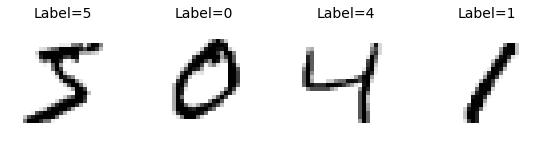

In [0]:
plt.figure(figsize=(8, 2))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(x_train[i].reshape(28, 28), 
               interpolation="none", cmap="gray_r")
    plt.title('Label=%d' % y_train[i], fontsize=14)
    plt.axis("off")
plt.tight_layout()

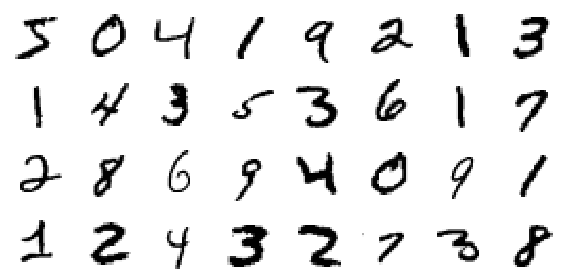

In [0]:
n_rows = 4
n_cols = 8
plt.figure(figsize=(8, 4))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(x_train[i].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    plt.axis("off")
plt.tight_layout()

The first character is a 5 digit, encoded in grayscale matrix.

We need to normalize the images and one-hot encode the labels.

In [0]:
x_train /= 255
x_test /= 255

In [0]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_train[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

### <font color=darkred> Softmax regression for MNIST</font>

Logistic regression can be extended to classify data in more than two groups. Softmax regression provides a model for the probability that an input $x$ is associated with each group.  It is assumed that the probability to belong to the class $k\in\{1,\ldots,M\}$ can be expressed by 
\begin{equation*}
\mathbb{P}(Y = k| X) = \frac{\exp(\langle w_k,X \rangle + b_k)}{\sum_{\ell=1}^{M}\exp(\langle w_\ell,X \rangle + b_\ell)} = p_k(X)\,,
\end{equation*}
where $w_\ell \in \mathbb{R}^d$ and $b_\ell$  are model `weights` and `intercepts` for each class.


To estimate these unknown parameters, a maximum likelihood approach is used as in the logistic regression setting. In this case, the loss function is given by the negative log-likelihood (see also the section on gradient based method).

To train the model weights $W_{k, j}$ and $b_k$ for $k=1, \ldots, 10$ and $j=1, \ldots, 784$, we consider the loss function given by the negative log-likelihood.
For the considered model, the negative log-likelihood of a sample with input $x_i \in \mathbb R^{784}$ and label $y_i \in \{0, 1\}^{10}$, it is given by the cross-entropy between the scores $p_k(x_i)$ and the label $y_i$:
$$
- \sum_{k=1}^{10} y_{i, k} \log(p_k(x_i))
$$
For this first model, we will simply use stochastic gradient descent over small batches of data. It can be done easily with TensorFlow, as it will automatically and efficiently compute the gradient from your graph, then apply an optimization algorithm of your choice to perform the parameters update.

In [0]:
model = Sequential()
# First we need to flatten the data: replace 28 * 28 matrices by flat vectors
# This is always necessary before feeding data to a fully-connected layer (Dense object)
model.add(Flatten(input_shape=input_shape, name='flatten'))

model.add(Dense(num_classes, activation='softmax', name='dense_softmax'))

model.compile(
    # specify the loss as the cross-entropy
    loss=keras.losses.categorical_crossentropy,
    # choose the Adagrad solver, but you can choose others
    optimizer=keras.optimizers.Adagrad(),
    # to monitor the accuracy on a testing set along optimization
    metrics=['accuracy']
)
model.summary()






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_softmax (Dense)        (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [0]:
batch_size = 150
epochs = 10

# Run the train
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 17us/step - loss: 0.2755 - acc: 0.9234 - val_loss: 0.2756 - val_acc: 0.9233
Epoch 2/10
60000/60000 [==============================] - 1s 16us/step - loss: 0.2753 - acc: 0.9234 - val_loss: 0.2754 - val_acc: 0.9235
Epoch 3/10
60000/60000 [==============================] - 1s 16us/step - loss: 0.2750 - acc: 0.9236 - val_loss: 0.2752 - val_acc: 0.9232
Epoch 4/10
60000/60000 [==============================] - 1s 16us/step - loss: 0.2747 - acc: 0.9235 - val_loss: 0.2750 - val_acc: 0.9235
Epoch 5/10
60000/60000 [==============================] - 1s 16us/step - loss: 0.2744 - acc: 0.9238 - val_loss: 0.2748 - val_acc: 0.9236
Epoch 6/10
60000/60000 [==============================] - 1s 16us/step - loss: 0.2741 - acc: 0.9239 - val_loss: 0.2746 - val_acc: 0.9234
Epoch 7/10
60000/60000 [==============================] - 1s 16us/step - loss: 0.2739 - acc: 0.9241 - val_loss: 0.2744 - val_acc

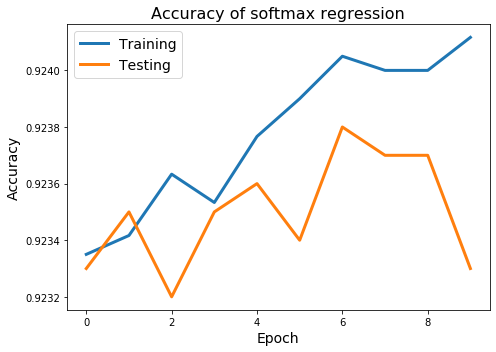

In [0]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['acc'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_acc'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

**Question**

Run a cross-validation to analyze the influence of the number of epochs and the batch-size.

Weight matrices plots show that the learned weights are consistant with the digits they should predict (see below).
You should be able to see rough shapes corresponding to the digits 0, 1, 2, 3, etc.

**Réponse**

Pour cette partie, on change la valeur des deux paramètres que l'on peut lire au début de la partie, à savoir le paramètre "batch_size" et le paramètre "epochs".
Lorsque l'on change la valeur de epochs, on change en réalité le nombre de fois où l'on va faire l'analyse. Ainsi, la précision devient plus grande quand on augmente cela. De même, lorsque l'on change la valeur de batch_size, on change en réalité la taille de l'échantillon. Ainsi, on se retrouve avec un apprentissage qui se fait sur un plus grand nombres d'éléments, et on peut donc avoir une adaptativité plus grande.


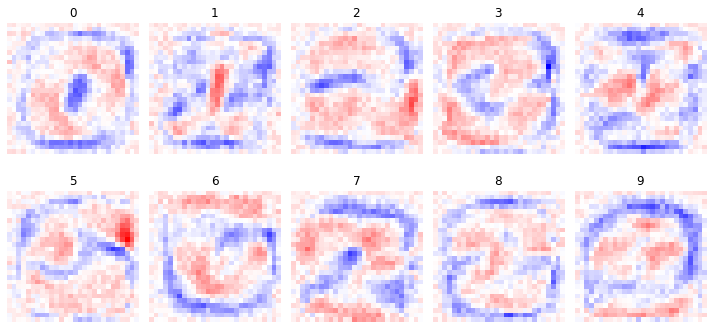

In [0]:
weights, biases = model.get_layer('dense_softmax').get_weights()
imgs = weights.reshape(28, 28, 10)

fig = plt.figure(figsize=(10, 5))
vmin, vmax = imgs.min(), imgs.max()
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    im = imgs[:, :, i]
    mappable = ax.imshow(im, interpolation="nearest", 
                         vmin=vmin, vmax=vmax, cmap='bwr')
    ax.axis('off')
    ax.set_title("%i" % i)
plt.tight_layout()

### <font color=darkred> Feed-Forward Neural Network (FFNN)</font>

The softmax regression you just trained is a linear model, with 7850 parameters. 
It is easy to fit, numerically stable, but might be too simple for some tasks. 
The idea behind neural networks is to have a nonlinear model, while keeping the nice features of linear ones. 
The idea is to keep parameters into linear functions, and link these small linear model using non linear operations.

A simple nonlinearity which is often used to do this is the rectified linear unit
$\text{ReLU}(x) = \max(0, x)$

The derivative of this function is very easy to compute, and it is parameter-free. If we stack models such as softmax regression and ReLUs, it is still very easy to compute the gradient using the chain rule, as the model is a combination of simple functions.

The backpropagation algorithm allows efficient computation of complex derivatives as long as the function is made of simple blocks with simple derivatives. 
This algorithm efficiency is based on data reuse: when working with parallel architectures such as GPUs, you want to minimize communication (data transfer) as it is very time consuming in comparison to the computing time.

**Question**

Create the graph for a fully connected feed-forward neural network with one hidden layer with 128 units and a relu activation function. 

In [0]:
model_ffnn = Sequential()

model_ffnn.add(Flatten(input_shape=input_shape))
model_ffnn.add(Dense(128, activation='relu')) #Ajout numéro 1
model_ffnn.add(Dense(num_classes, activation='softmax')) #La dernière couche ici, un vecteur avec le nombre de classe 
#plus avec softmax

model_ffnn.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adagrad(),
    metrics=['accuracy']
)

model_ffnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [0]:
batch_size = 32
epochs = 10

# Run the train
history = model_ffnn.fit(x_train, y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(x_test, y_test))
score = model_ffnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 102us/step - loss: 0.2681 - acc: 0.9235 - val_loss: 0.1948 - val_acc: 0.9459
Epoch 2/10
60000/60000 [==============================] - 6s 96us/step - loss: 0.1676 - acc: 0.9533 - val_loss: 0.1562 - val_acc: 0.9555
Epoch 3/10
60000/60000 [==============================] - 6s 96us/step - loss: 0.1403 - acc: 0.9608 - val_loss: 0.1373 - val_acc: 0.9603
Epoch 4/10
60000/60000 [==============================] - 6s 99us/step - loss: 0.1237 - acc: 0.9659 - val_loss: 0.1257 - val_acc: 0.9644
Epoch 5/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.1122 - acc: 0.9688 - val_loss: 0.1199 - val_acc: 0.9659
Epoch 6/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.1036 - acc: 0.9713 - val_loss: 0.1131 - val_acc: 0.9677
Epoch 7/10
60000/60000 [==============================] - 6s 95us/step - loss: 0.0965 - acc: 0.9735 - val_loss: 0.1074 - val_ac

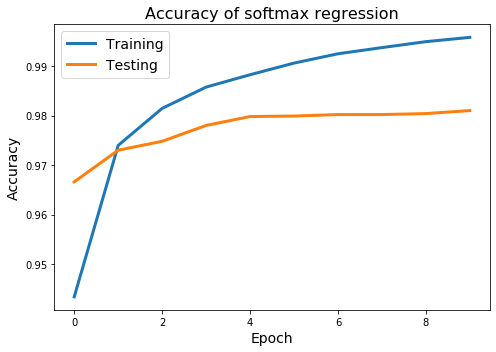

In [0]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['acc'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_acc'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

**Question**

Run a cross-validation to analyze the influence of the the number of units of the hidden layer, the number of epochs and the batch-size.

**Réponse**

On peut regarder l'influence de ces trois paramètres :

*   Le paramètre "number of unit of the hidden layer" correspond au nombre de couche que l'on va utiliser avec la couche. Plus le nombre est grand, plus l'analyse sera longue. Toutefois, on peut tester avec une valeur plus élevée et l'on aura une précision plus grande.
*   Ensuite on peut faire varier le paramètre "epoch" : encore une fois, il sera plus long de trouver le résultat mais celui-ci sera plus précis quand on augmente la valeur du paramètre.
*   Enfin, on peut analyser la valeur de batch-size : encore une fois, l'augmentation de la valeur de ce paramètre augmente la valeur de la précision donnée par "test_accuary" mais cela rend le traitement plus.




### <font color=darkred> Convolutional Neural Networks </font>

In practice, increasing the size of hidden layers is not very effective. 
It is often a better idea to add more layers. 
Intuitively, if the observations have a hierarchical structure, adding more layers can be interpreted as a way to learn more levels of abstraction.  For example, in object detection tasks, it is easier to express shapes from edges and objects from shapes, than to express objects from pixels.  Thus, a good design should try to exploit this hierarchy.

In particular cases, such as grid-like data (time series, images), the observations can depend on a pattern which can be associated with different locations of the data. 
For example, an object can be in the middle or the left of the picture. 
Thus, the model has to be translation invariant: it is easier to learn how to recognize an object independently of its location. 

When two inputs might contain the same kind of information, then it is useful to share their weights and estimate the weights jointly for those inputs to learn statistical invariants (things that don't change much on average across time or space). 
Using this concept on images leads to convolutional neural networks (CNNs), on text, it results on recurrent neural networks (RNNs).  When using CNNs, weights are set to a small kernel that is used to perform a convolution across the image.

In the previous example, the step ``model_ffnn.add(Flatten(input_shape=input_shape))`` destroys the spatial organization of the input but is mandatory before the fully connected step: ``model_ffnn.add(Dense(128, activation='relu'))``. The spatial organization of the input may be preserved before using Flatten by convolution steps such as ``model_cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))``. This layer has 32 outputs, each of which depending on a 3*3 weight matrix.

Each output neuron of the next layer is computed as follows (image taken from https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-tensorflow/) before computing an elementwise RELU function:
<img src="conv.PNG">

The convolution maps patches of the input image, combined with the convolution kernel, for example
$$
\text{output} = \text{ReLU}(\text{patch} \times W + b)\,.
$$

Performing the convolution between the image and the weight matrix consists in moving the kernel across the image, and to produce an output for each patch. The way you move across the image is defined by two parameters:

- ``Stride``: the stride is the number of pixels you are shifting each time you move your kernel during the convolution.
- ``Padding``: defines what happens when the kernel reaches a border of the image when doing the convolution. 
"Valid" padding means that you stop at the edge, while "Same" padding allows to go off the edge and pad with zeros so that the width and the height of the output and input tensors are the same.

A classical approach is to use a stride of 1 and to combine theoutputs being in some neighborhood. Such an operation combining elements of a tensor is called ``pooling``: ``model_cnn.add(MaxPooling2D(pool_size=(2, 2)))``. Neighborhoods are define by the pooling window dimension (width x height) and the strides you use when moving this window across the image.  Again, a sliding window is applied along the input to produce the output, the most common function applied on each window being the ma function: it aggregates several outputs in a neighborhood $N$ using a max operation: 
$$
\text{output}'_i = \max_{j \in N}\text{output}_j, \quad i \in N.
$$
The formulas to compute the size of the ouput tensor are the same as for convolution padding and striding: (image taken from https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-tensorflow/):
<img src="maxpool.PNG">

In [0]:
model_cnn = Sequential()

model_cnn.add(Conv2D(32,kernel_size=(3, 3), activation='relu', input_shape=input_shape))#On sort une matrice des moyennes des 32 matrices
model_cnn.add(MaxPooling2D(pool_size=(2,2)))
model_cnn.add(Conv2D(32,kernel_size=(3,3),activation='relu', input_shape=input_shape))
#model_cnn.add(Conv2D(32,kernel_size=(1,1),activation='relu', input_shape=input_shape)) #Pour des convolutions en 3D généralement

model_cnn.add(Flatten(input_shape=input_shape, name='flatten')) #Applatir la matrice des moyennes
model_cnn.add(Dense(num_classes, activation='softmax'))#Fonction d'activation softmax, on veut 10 sorties à la fin

                    
model_cnn.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

model_cnn.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                38730     
Total params: 48,298
Trainable params: 48,298
Non-trainable params: 0
_________________________________________________________________


In [0]:
batch_size = 32
epochs = 5

# Run the train
history = model_cnn.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
score = model_cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 46s 769us/step - loss: 0.1649 - acc: 0.9503 - val_loss: 0.0582 - val_acc: 0.9821
Epoch 2/5
60000/60000 [==============================] - 46s 769us/step - loss: 0.0638 - acc: 0.9811 - val_loss: 0.0439 - val_acc: 0.9851
Epoch 3/5
60000/60000 [==============================] - 47s 777us/step - loss: 0.0505 - acc: 0.9851 - val_loss: 0.0365 - val_acc: 0.9876
Epoch 4/5
60000/60000 [==============================] - 47s 783us/step - loss: 0.0408 - acc: 0.9880 - val_loss: 0.0364 - val_acc: 0.9891
Epoch 5/5
60000/60000 [==============================] - 46s 773us/step - loss: 0.0363 - acc: 0.9898 - val_loss: 0.0354 - val_acc: 0.9889
Test loss: 0.03541457466912689
Test accuracy: 0.9889


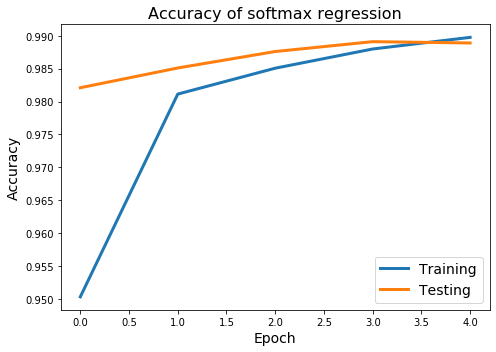

In [0]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['acc'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_acc'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

### <font color=darkred> notMNIST</font>

MNIST is a very very **clean** dataset. Digits are rescaled, smoothed, centered, and pixel values are normalized beforehand. Let's switch to a slightly harder dataset: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

This time, labels are letters from 'A' to 'J' (10 classes). 
These letters are taken from digital fonts instead of handwriting pictures. 
We will use a reduced amount of data to ensure a reasonable training time. 
The training set you will use has 200K labelled examples, while the validation and test sets both contain 10K labelled examples.

In [0]:
import urllib

# Importation des données

In [0]:
#Importation du document sur le Google Drive
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Projet Deep Learning/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
conv.PNG  maxpool.PNG  notMNIST.pickle	projet_deep_learning_I.ipynb


In [0]:
pickle_file = '/content/drive/My Drive/Projet Deep Learning/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    data = pkl.load(f)

In [0]:
data.keys()

dict_keys(['test_dataset', 'valid_labels', 'test_labels', 'train_dataset', 'train_labels', 'valid_dataset'])

In [0]:


def reshape(x, image_data_format, img_rows, img_cols):
    if image_data_format == 'channels_first':
        return x.astype(np.float32).reshape((-1, 1, img_rows, img_cols))
    else:
        return x.astype(np.float32).reshape((-1, img_rows, img_cols, 1))

img_rows, img_cols = 28, 28
num_labels = 10
image_data_format = K.image_data_format()

if image_data_format == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)
    
x_train = reshape(data['train_dataset'], image_data_format, img_rows, img_cols)
x_valid = reshape(data['valid_dataset'], image_data_format, img_rows, img_cols)
x_test = reshape(data['test_dataset'], image_data_format, img_rows, img_cols)

y_train = keras.utils.to_categorical(data['train_labels'])
y_valid = keras.utils.to_categorical(data['valid_labels'])
y_test = keras.utils.to_categorical(data['test_labels'])

print('x_train shape:', x_train.shape)
print('x_valid shape:', x_valid.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'training samples')
print(x_valid.shape[0], 'validation samples')
print(x_test.shape[0], 'testing samples')

x_train shape: (200000, 28, 28, 1)
x_valid shape: (10000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (200000, 10)
y_valid shape: (10000, 10)
y_test shape: (10000, 10)
200000 training samples
10000 validation samples
10000 testing samples


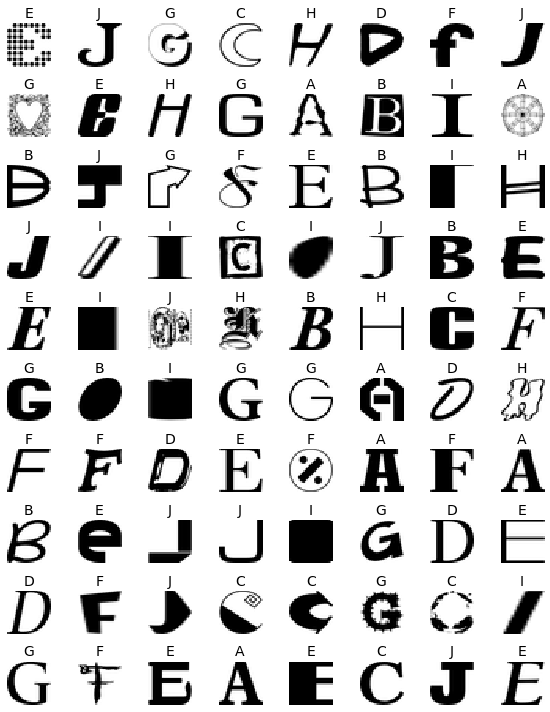

In [0]:
# plt.figure(figsize=(8, 4))
n_rows = 10
n_cols = 8
plt.figure(figsize=(n_cols, n_rows))

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
def get_label(y):
    return letters[y.argmax()]

for i in range(n_rows * n_cols):
    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.imshow(x_train[i].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    ax.set_title(get_label(y_train[i]), fontsize=14)
    ax.axis("off")
plt.tight_layout()

**Question**

Train a softmax regression, visualize the weights, plot the convergence curves, save the model and its history (start with a small number of epochs, and increase the number of epochs).

In [0]:
#Réponse à la question posée

model = Sequential()
# First we need to flatten the data: replace 28 * 28 matrices by flat vectors
# This is always necessary before feeding data to a fully-connected layer (Dense object)
model.add(Flatten(input_shape=input_shape, name='flatten'))

model.add(Dense(num_classes, activation='softmax', name='dense_softmax'))

model.compile(
    # specify the loss as the cross-entropy
    loss=keras.losses.categorical_crossentropy,
    # choose the Adagrad solver, but you can choose others
    optimizer=keras.optimizers.Adagrad(),
    # to monitor the accuracy on a testing set along optimization
    metrics=['accuracy']
)
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_softmax (Dense)        (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [0]:
#Réponse à la question : Entrainement des données
batch_size = 64
epochs = 10

# Run the train
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 200000 samples, validate on 10000 samples
Epoch 1/10
200000/200000 [==============================] - 5s 24us/step - loss: 1.7965 - acc: 0.6957 - val_loss: 0.7297 - val_acc: 0.8493
Epoch 2/10
200000/200000 [==============================] - 5s 25us/step - loss: 1.0190 - acc: 0.7877 - val_loss: 0.5722 - val_acc: 0.8690
Epoch 3/10
200000/200000 [==============================] - 5s 24us/step - loss: 0.8581 - acc: 0.8016 - val_loss: 0.5045 - val_acc: 0.8785
Epoch 4/10
200000/200000 [==============================] - 5s 25us/step - loss: 0.7775 - acc: 0.8094 - val_loss: 0.4718 - val_acc: 0.8814
Epoch 5/10
200000/200000 [==============================] - 5s 25us/step - loss: 0.7333 - acc: 0.8147 - val_loss: 0.4535 - val_acc: 0.8846
Epoch 6/10
200000/200000 [==============================] - 5s 27us/step - loss: 0.7071 - acc: 0.8182 - val_loss: 0.4414 - val_acc: 0.8871
Epoch 7/10
200000/200000 [==============================] - 5s 26us/step - loss: 0.6903 - acc: 0.8211 - val_loss: 0

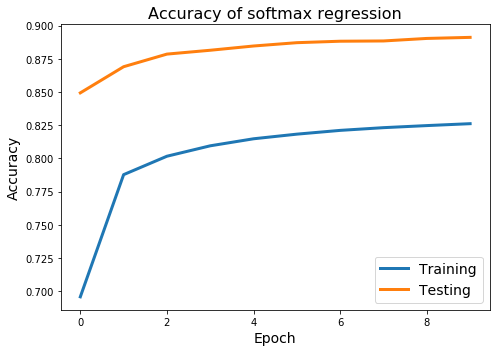

In [0]:
#Réponse à la question : Calcul des poids + Graphique
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['acc'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_acc'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

**Le test nest pas probant : on ne reconnait pas les images, le modèle est sous entrainé, car il y a des cas dans lesquels on n'a pas affaire à une lettre mais on a un symbole (police d'écriture symbole).** 

**Question**

Train FFNN with one hidden layer with 128 units, visualize the convergence curves, save the history.

In [0]:
model_ffnn = Sequential()

model_ffnn.add(Flatten(input_shape=input_shape))
model_ffnn.add(Dense(128, activation='relu')) #Ajout numéro 1
model_ffnn.add(Dense(num_classes, activation='softmax')) #La dernière couche ici, un vecteur avec le nombre de classe 
#plus avec softmax

model_ffnn.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adagrad(),
    metrics=['accuracy']
)

model_ffnn.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [0]:
batch_size = 32
epochs = 10

# Run the train
history = model_ffnn.fit(x_train, y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(x_test, y_test))
score = model_ffnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 200000 samples, validate on 10000 samples
Epoch 1/10
200000/200000 [==============================] - 19s 97us/step - loss: 0.3562 - acc: 0.8973 - val_loss: 0.2005 - val_acc: 0.9438
Epoch 2/10
200000/200000 [==============================] - 19s 96us/step - loss: 0.3510 - acc: 0.8989 - val_loss: 0.1979 - val_acc: 0.9445
Epoch 3/10
200000/200000 [==============================] - 21s 105us/step - loss: 0.3465 - acc: 0.9002 - val_loss: 0.1952 - val_acc: 0.9458
Epoch 4/10
200000/200000 [==============================] - 20s 98us/step - loss: 0.3426 - acc: 0.9015 - val_loss: 0.1946 - val_acc: 0.9459
Epoch 5/10
200000/200000 [==============================] - 19s 97us/step - loss: 0.3390 - acc: 0.9024 - val_loss: 0.1924 - val_acc: 0.9449
Epoch 6/10
200000/200000 [==============================] - 19s 96us/step - loss: 0.3358 - acc: 0.9033 - val_loss: 0.1917 - val_acc: 0.9474
Epoch 7/10
200000/200000 [==============================] - 19s 97us/step - loss: 0.3327 - acc: 0.9042 - val

**Réponse**

Dans cette partie, on tente une analyse avec une méthode différente. On se propose de réaliser un apprentissage avec un modèle basé sur une FFNN, avec une seule couche.

Dans ce cas, on peut voir que le modèle est plus précis : en effet, on obtient cette fois-ci une précision bien plus grande : environ 0.95 avec ce modèle contre seulement environ 0.89 pour la méthode précédente.

On peut donc se dire que cette méthode est meilleure, mais l'on n'a encore pas un résultat suffisant : il faudrait un écart entre la partie entrainée et la partie testée qui soit bien moindre.

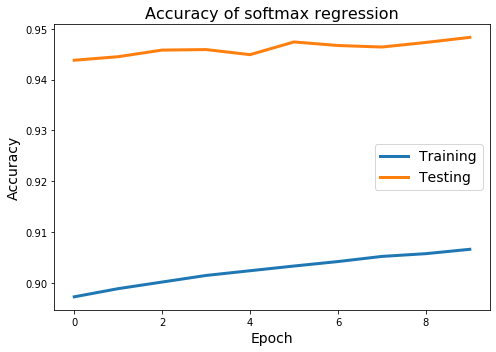

In [0]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['acc'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_acc'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

**Question**

Train a CNN with the following structure:

1. Convolutional layer with 32 filters and 5 * 5 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Convolutional layer with 64 filters and 5 * 5 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Dropout with probability 0.25 (réduit l'apprentisage, cf sur Internet)
- Dense layer with 1024 units
- Dropout with probability 0.5
- Dense output layer with softmax activation

Use the Adam solver. Train for 20 epochs.

In [0]:
model_cnn = Sequential()

model_cnn.add(Conv2D(32,kernel_size=(5, 5), activation='relu', input_shape=input_shape))#On sort une matrice des moyennes des 32 matrices
model_cnn.add(MaxPooling2D(pool_size=(2,2)))
model_cnn.add(Conv2D(64,kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model_cnn.add(MaxPooling2D(pool_size=(2,2)))
model_cnn.add(Dropout(0.25,noise_shape=None,seed=None))
model_cnn.add(Dense(1024, activation='softmax', name='dense_softmax'))
model_cnn.add(Dropout(0.5,noise_shape=None,seed=None))

model_cnn.add(Flatten(input_shape=input_shape, name='flatten')) #Applatir la matrice des moyennes
model_cnn.add(Dense(num_classes, activation='softmax'))#Fonction d'activation softmax, on veut 10 sorties à la fin

                    
model_cnn.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 4, 4, 64)          0         
_________________________________________________________________
dense_softmax (Dense)        (None, 4, 4, 1024)        66560     
_________________________________________________________________
dropout_8 (Dropout)          (None, 4, 4, 1024)      

In [0]:
batch_size = 32
epochs = 5

# Run the train
history = model_cnn.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
score = model_cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 200000 samples, validate on 10000 samples
Epoch 1/5
200000/200000 [==============================] - 430s 2ms/step - loss: 1.3606 - acc: 0.5350 - val_loss: 0.3809 - val_acc: 0.8921
Epoch 2/5
200000/200000 [==============================] - 446s 2ms/step - loss: 0.6906 - acc: 0.7983 - val_loss: 0.2800 - val_acc: 0.9192
Epoch 3/5
200000/200000 [==============================] - 455s 2ms/step - loss: 0.6043 - acc: 0.8251 - val_loss: 0.2422 - val_acc: 0.9294
Epoch 4/5
200000/200000 [==============================] - 454s 2ms/step - loss: 0.5544 - acc: 0.8395 - val_loss: 0.2172 - val_acc: 0.9363
Epoch 5/5
200000/200000 [==============================] - 448s 2ms/step - loss: 0.5210 - acc: 0.8497 - val_loss: 0.2069 - val_acc: 0.9397
Test loss: 0.2068765182197094
Test accuracy: 0.9397


**Question**

Run a cross-validation to analyze the influence of the kernel sizes (step 1 and 3), the activation functions (step 1 and 3) and the number of units of the hidden layer (step 6).

### <font color=darkred> Simple Recurrent neural networks</font>

In [2]:
from keras.layers.recurrent import SimpleRNN
from keras.datasets import imdb
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.preprocessing import sequence

Using TensorFlow backend.


**IMDB sentiment classification task**

This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets.

IMDB provided a set of 25,000 highly popular movie reviews for training, and 25,000 for testing.

Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

See here: https://keras.io/datasets/

In [4]:
# Top most frequent words to consider, other words are discarded
# Number of words considered as different features
max_features = 1000

# Maximum sequence length. Any longer sequence will be truncated.
maxlen = 50 

(x_train, y_train), (x_test, y_test) = imdb.load_data(nb_words = max_features)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


# Build the sequences of maxlen words for each sample
x_train = sequence.pad_sequences(x_train, maxlen = maxlen)
x_test = sequence.pad_sequences(x_test, maxlen = maxlen)
print('X_train shape:', x_train.shape)
print('X_test shape:', x_test.shape)


    8192/17464789 [..............................] - ETA: 0s

/usr/local/lib/python3.6/dist-packages/keras/datasets/imdb.py:49: UserWarning: The `nb_words` argument in `load_data` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `load_data` '


17465344/17464789 [==============================] - 0s 0us/step
25000 train samples
25000 test samples
y_train shape: (25000,)
y_test shape: (25000,)
X_train shape: (25000, 50)
X_test shape: (25000, 50)


In [5]:
model_rnn = Sequential()

# Embedding layer, turns positive integers or indices into dense vectors of fixed size
model_rnn.add(Embedding(max_features, 32))
model_rnn.add(SimpleRNN(32))  
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(1, activation='sigmoid', name='dense_sigmoid'))

model_rnn.compile(loss='binary_crossentropy', optimizer='adam')

model_rnn.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_sigmoid (Dense)        (None, 1)                 33        
Total params: 34,113
Trainable params: 34,113
Non-trainable params: 0
_________________________________________________________________


In [1]:
batch_size = 32
epochs = 5

history = model_rnn.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))

NameError: ignored

**Question**

Run a cross-validation to analyze the influence of the size of the RNN layer and of the embedding layer.

**Question (bonus)**

You may try to implement a first LSTM on this example (see next practical session).